In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [7]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

In [3]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


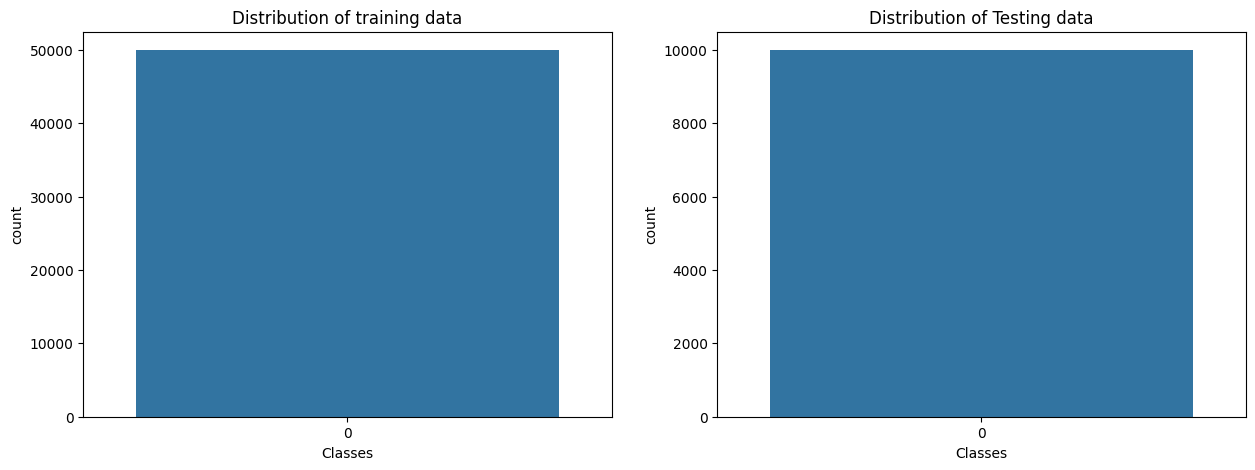

In [8]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [9]:
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/100
 668/1563 ━━━━━━━━━━━━━━━━━━━━ 1:06 75ms/step - accuracy: 0.1798 - loss: 2.1769

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)